# Trend Line Breakout Machine Learning Algorithmic Trading Strategy in Python

I show a Trend Line breakout  trend following strategy and improve the results by meta-labeling the trades. Then train a random forest to predict when a trade will succeed or fail.

* Tutorial: [Trend Line Breakout Machine Learning Algorithmic Trading Strategy in Python](https://www.youtube.com/watch?v=jCBnbQ1PUkE)
* Code: https://github.com/neurotrader888/TrendlineBreakoutMetaLabel

Links

- https://en.wikipedia.org/wiki/Bootstrap_aggregating
- https://en.wikipedia.org/wiki/Random_forest

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
import sklearn
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from src.trendline_automation import fit_trendlines_single, fit_trendlines_single, fit_upper_trendline

### Trendline Breakout

In [2]:
def trendline_breakout(close: np.array, lookback:int):
    s_tl = np.zeros(len(close))
    s_tl[:] = np.nan

    r_tl = np.zeros(len(close))
    r_tl[:] = np.nan

    sig = np.zeros(len(close))

    for i in range(lookback, len(close)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line, projected forward to current bar
        s_val = s_coefs[1] + lookback * s_coefs[0] 
        r_val = r_coefs[1] + lookback * r_coefs[0] 

        s_tl[i] = s_val
        r_tl[i] = r_val

        if close[i] > r_val:
            sig[i] = 1.0
        elif close[i] < s_val:
            sig[i] = -1.0
        else:
            sig[i] = sig[i - 1]

    return s_tl, r_tl, sig

In [3]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

In [4]:
lookback = 72
support, resist, signal = trendline_breakout(data['close'].to_numpy(), lookback)
data['support'] = support
data['resist'] = resist
data['signal'] = signal

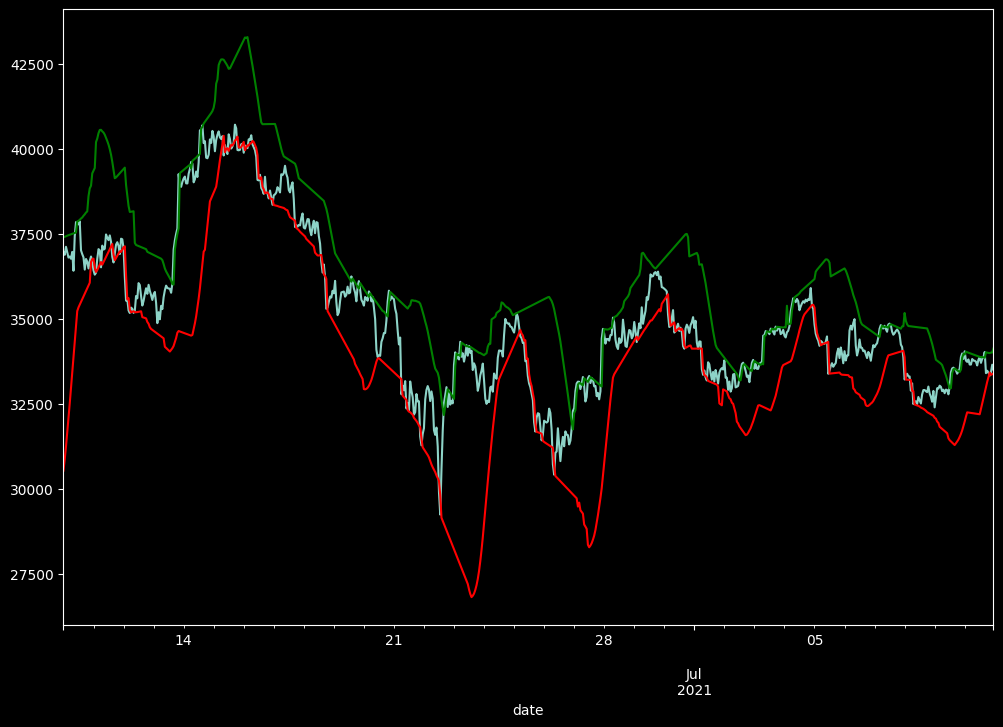

In [5]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
plt_data = data['2021-06-10':'2021-07-10']
plt_data['close'].plot(label='Close')
plt_data['resist'].plot(label='Resistance', color='green')
plt_data['support'].plot(label='Support', color='red')
plt.show()

Profit Factor 72 1.0353848663195326


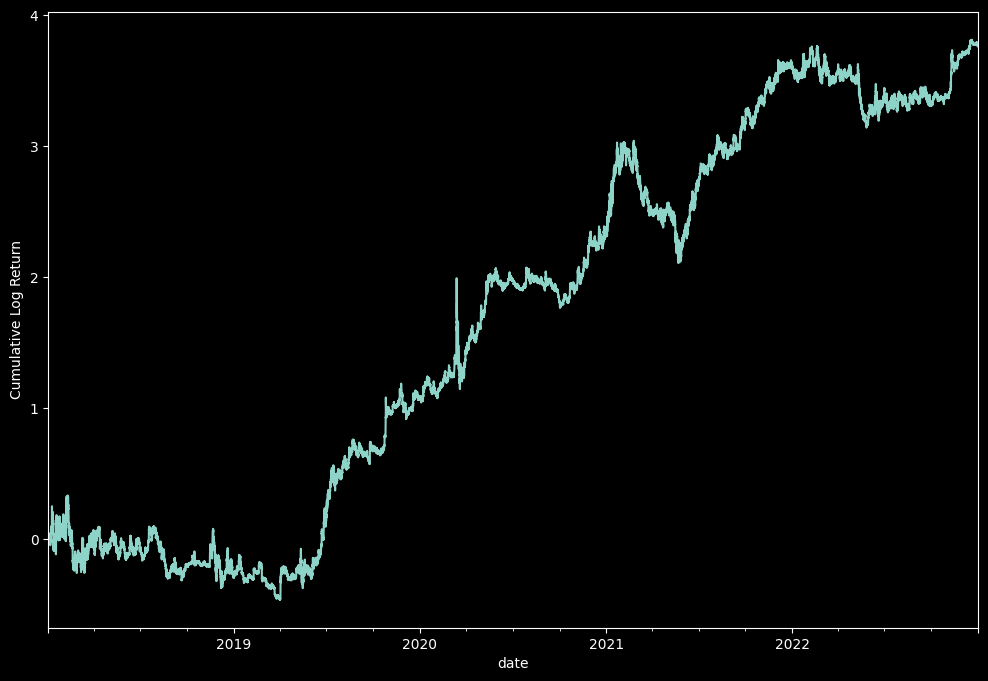

In [6]:
data['r'] = np.log(data['close']).diff().shift(-1)
strat_r = data['signal'] * data['r']

pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum() 
print("Profit Factor", lookback,  pf)

plt.figure(figsize=(12, 8))
strat_r.cumsum().plot()
plt.ylabel("Cumulative Log Return")
plt.show()

In [7]:
lookbacks = list(range(24, 169, 2))
pfs = []

lookback_returns = pd.DataFrame()
for lookback in tqdm(lookbacks):
    support, resist, signal = trendline_breakout(data['close'].to_numpy(), lookback)
    data['signal'] = signal

    data['r'] = np.log(data['close']).diff().shift(-1)
    strat_r = data['signal'] * data['r']

    pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum() 
    #print("Profit Factor", lookback,  pf)
    pfs.append(pf)

    lookback_returns[lookback] = strat_r

100%|███████████████████████████████████████████████████████████████████| 73/73 [11:11<00:00,  9.19s/it]


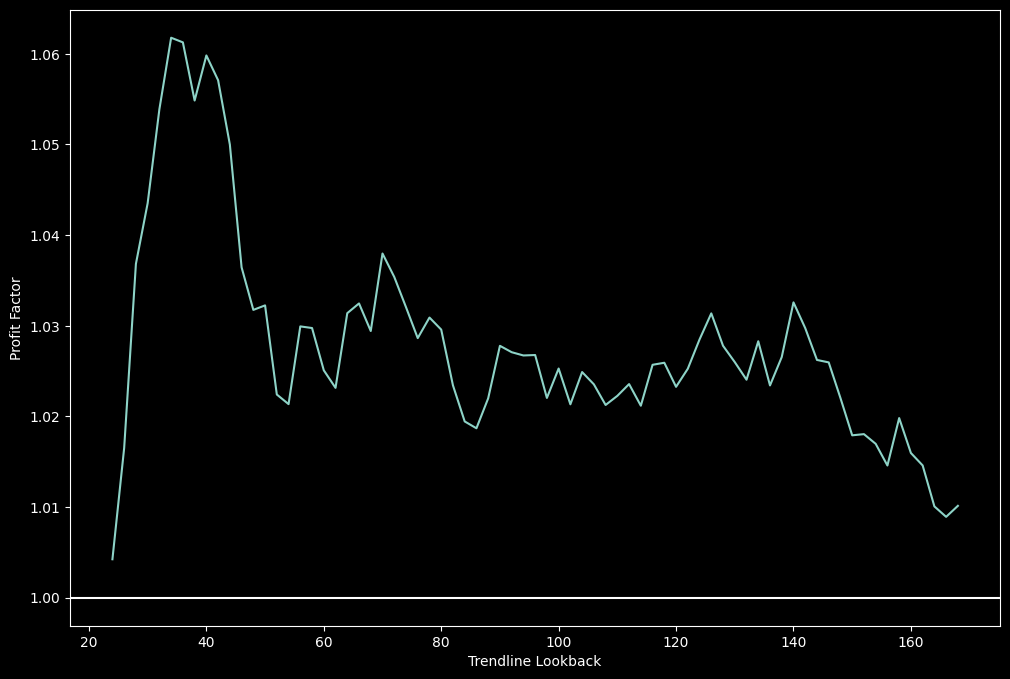

In [8]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
x = pd.Series(pfs, index=lookbacks)
x.plot()
plt.ylabel("Profit Factor")
plt.xlabel("Trendline Lookback")
plt.axhline(1.0, color='white')

### Meta Label Model

In [9]:
def trendline_breakout_dataset(
        ohlcv: pd.DataFrame, lookback: int, 
        hold_period:int=12, tp_mult: float=3.0, sl_mult: float=3.0, 
        atr_lookback: int=168
):
    assert(atr_lookback >= lookback)

    close = np.log(ohlcv['close'].to_numpy())
   
    # ATR for normalizing, setting stop loss take profit
    atr = ta.atr(np.log(ohlcv['high']), np.log(ohlcv['low']), np.log(ohlcv['close']), atr_lookback)
    atr_arr = atr.to_numpy()
   
    # Normalized volume
    vol_arr = (ohlcv['volume'] / ohlcv['volume'].rolling(atr_lookback).median()).to_numpy() 
    adx = ta.adx(ohlcv['high'], ohlcv['low'], ohlcv['close'], lookback)
    adx_arr = adx['ADX_' + str(lookback)].to_numpy()

    trades = pd.DataFrame()
    trade_i = 0

    in_trade = False
    tp_price = None
    sl_price = None
    hp_i = None
    for i in range(atr_lookback, len(ohlcv)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line
        r_val = r_coefs[1] + lookback * r_coefs[0]

        # Entry
        if not in_trade and close[i] > r_val:
            
            tp_price = close[i] + atr_arr[i] * tp_mult
            sl_price = close[i] - atr_arr[i] * sl_mult
            hp_i = i + hold_period
            in_trade = True

            trades.loc[trade_i, 'entry_i'] = i
            trades.loc[trade_i, 'entry_p'] = close[i]
            trades.loc[trade_i, 'atr'] = atr_arr[i]
            trades.loc[trade_i, 'sl'] = sl_price 
            trades.loc[trade_i, 'tp'] = tp_price 
            trades.loc[trade_i, 'hp_i'] = i + hold_period
            
            trades.loc[trade_i, 'slope'] = r_coefs[0]
            trades.loc[trade_i, 'intercept'] = r_coefs[1]


            # Trendline features
            # Resist slope
            trades.loc[trade_i, 'resist_s'] = r_coefs[0] / atr_arr[i] 
       
            # Resist erorr
            line_vals = (r_coefs[1] + np.arange(lookback) * r_coefs[0])
            err = np.sum(line_vals  - window ) / lookback
            err /= atr_arr[i]
            trades.loc[trade_i, 'tl_err'] = err

            # Max distance from resist
            diff = line_vals - window
            trades.loc[trade_i, 'max_dist'] = diff.max() / atr_arr[i]

            # Volume on breakout
            trades.loc[trade_i, 'vol'] = vol_arr[i]

            # ADX
            trades.loc[trade_i, 'adx'] = adx_arr[i]


        if in_trade:
            if close[i] >= tp_price or close[i] <= sl_price or i >= hp_i:
                trades.loc[trade_i, 'exit_i'] = i
                trades.loc[trade_i, 'exit_p'] = close[i]
                
                in_trade = False
                trade_i += 1

    trades['return'] = trades['exit_p'] - trades['entry_p']
    
    # Features
    data_x = trades[['resist_s', 'tl_err', 'vol', 'max_dist', 'adx']]
    # Label
    data_y = pd.Series(0, index=trades.index)
    data_y.loc[trades['return'] > 0] = 1

    return trades, data_x, data_y

In [10]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

In [11]:
trades, data_x, data_y = trendline_breakout_dataset(data, 72)

# Drop any incomplete trades
trades = trades.dropna()

# Look at trades without any ML filter.
signal = np.zeros(len(data))
for i in range(len(trades)):
    trade = trades.iloc[i]
    signal[int(trade['entry_i']):int(trade['exit_i'])] = 1.

data['r'] = np.log(data['close']).diff().shift(-1)
data['sig'] = signal
returns = data['r'] * data['sig']

print("Profit Factor", returns[returns > 0].sum() / returns[returns < 0].abs().sum())
print("Win Rate", len(trades[trades['return'] > 0]) / len(trades))
print("Average Trade", trades['return'].mean())

Profit Factor 1.0208446566508662
Win Rate 0.5034071550255537
Average Trade 0.0005262932569124696


Text(0, 0.5, 'Cumulative Log Return')

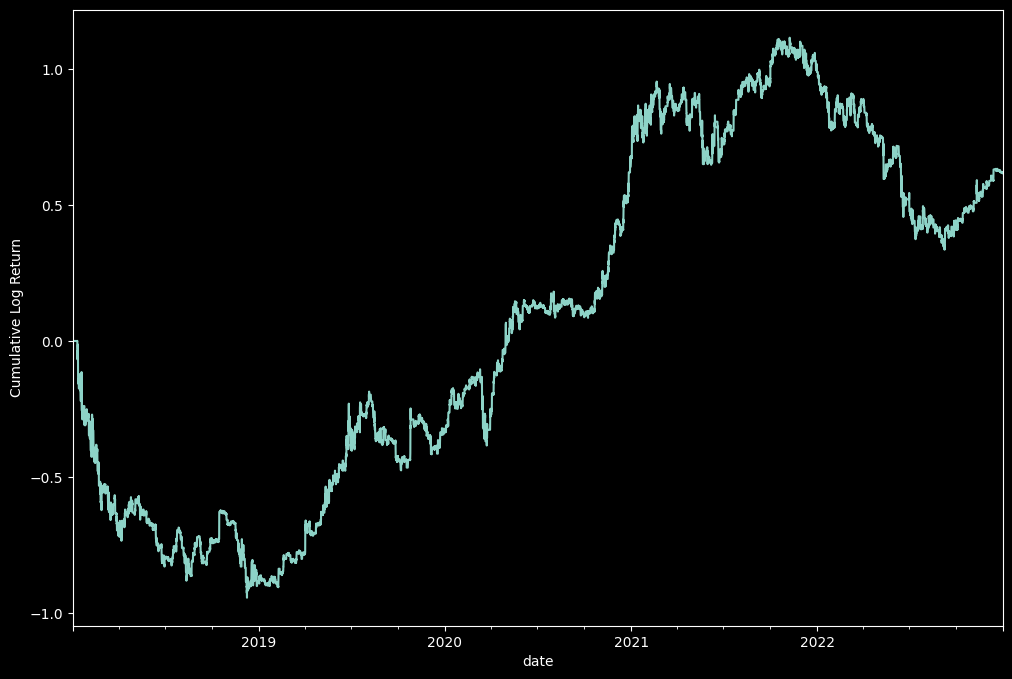

In [12]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
returns.cumsum().plot()
plt.ylabel("Cumulative Log Return")

### Random Forest

In [13]:
def plot_trade(ohlc: pd.DataFrame, trades: pd.DataFrame, trade_i: int, lookback: int):
    plt.style.use('dark_background')

    trade = trades.iloc[trade_i]
    entry_i = int(trade['entry_i'])
    exit_i = int(trade['exit_i']) 
    
    candles = np.log(ohlc.iloc[entry_i - lookback:exit_i+1])
    resist = [(candles.index[0], trade['intercept']), (candles.index[lookback], trade['intercept'] + trade['slope'] * lookback)]
    tp = [(candles.index[lookback], trade['tp']), (candles.index[-1], trade['tp'])]
    sl = [(candles.index[lookback], trade['sl']), (candles.index[-1], trade['sl'])]

    mco = [None] * len(candles)
    mco[lookback] = 'blue'
    fig, axs = plt.subplots(2, sharex=True, height_ratios=[3, 1])
    axs[1].set_title('Volume')

    mpf.plot(candles, volume=axs[1], alines=dict(alines=[resist, tp, sl], colors=['w', 'b', 'r']), type='candle', style='charles', ax=axs[0], marketcolor_overrides=mco)
    plt.show()

In [14]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()
data = data[data.index < '2019-01-01']

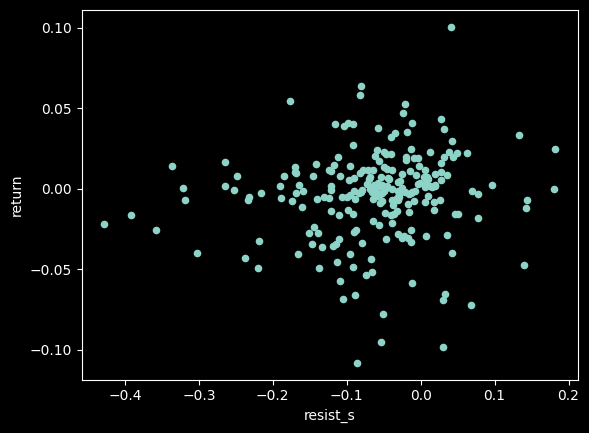

In [15]:
plt.style.use('dark_background')

trades, data_x, data_y = trendline_breakout_dataset(data, 72)
trades.plot.scatter('resist_s', 'return')
plt.show()

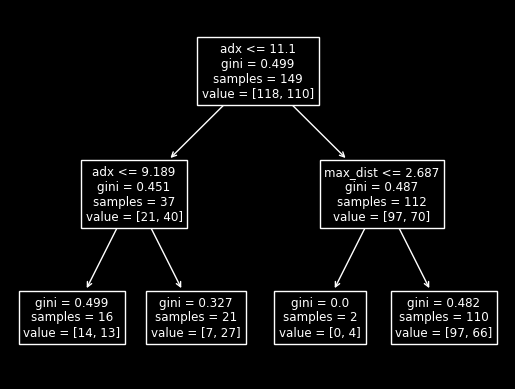

In [16]:
plt.style.use('dark_background')
ax = plt.gca()
model = RandomForestClassifier(max_depth=2)
model.fit(data_x, data_y)
sklearn.tree.plot_tree(model.estimators_[0], feature_names=data_x.columns, ax=ax)
plt.show()

### Walk Forward

In [17]:
def walkforward_model(
        close: np.array, trades:pd.DataFrame, 
        data_x: pd.DataFrame, data_y: pd.Series, 
        train_size: int, step_size: int
):
    
    signal = np.zeros(len(close))
    prob_signal = np.zeros(len(close))

    next_train = train_size
    trade_i = 0

    in_trade = False
    tp_price = None
    sl_price = None
    hp_i = None
      

    model = None 
    for i in range( len(close)):
        if i == next_train:
            start_i = i - train_size

            train_indices = trades[(trades['entry_i'] > start_i) & (trades['exit_i'] < i)].index

            x_train = data_x.loc[train_indices]
            y_train = data_y.loc[train_indices]
            print('training', i, 'N cases', len(train_indices))
            model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=69420)
            model.fit(x_train.to_numpy(), y_train.to_numpy())

            next_train += step_size
        
        if in_trade:
            if close[i] >= tp_price or close[i] <= sl_price or i >= hp_i:
                signal[i] = 0
                prob_signal[i] = 0
                in_trade = False
            else:
                signal[i] = signal[i - 1]
                prob_signal[i] = prob_signal[i - 1]


        if  trade_i < len(trades) and i == trades['entry_i'].iloc[trade_i]:
            
            if model is not None:
                prob = model.predict_proba(data_x.iloc[trade_i].to_numpy().reshape(1, -1))[0][1]
                prob_signal[i] = prob

                trades.loc[trade_i, 'model_prob'] = prob

                if prob > 0.5: # greater than 50%, take trade
                    signal[i] = 1
                
                in_trade = True
                trade = trades.iloc[trade_i]
                tp_price = trade['tp'] 
                sl_price = trade['sl'] 
                hp_i = trade['hp_i'] 

            trade_i += 1

    return signal, prob_signal

In [18]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

In [19]:
trades, data_x, data_y = trendline_breakout_dataset(data, 72)
signal, prob = walkforward_model(
        np.log(data['close']).to_numpy(), 
        trades, data_x, data_y, 
        365 * 24 * 2, 365 * 24
)

training 17520 N cases 454
training 26280 N cases 471
training 35040 N cases 481
training 43800 N cases 473


In [20]:
data['sig'] = signal

# dumb_sig takes every trade, no ML filter
data['dumb_sig'] = prob
data.loc[data['dumb_sig'] > 0, 'dumb_sig'] = 1
   
data = data[data.index > '2020-01-01']
data['r'] = np.log(data['close']).diff().shift(-1)


# Compute trade stats for all trades vs. model's selected trades
trades = trades.dropna() 
all_r = trades['return']    
mod_r = trades[trades['model_prob'] > 0.5]['return']

no_filter_rets = data['r'] * data['dumb_sig']
filter_rets = data['r'] * data['sig']

def prof_factor(rets):
    return rets[rets>0].sum() / rets[rets<0].abs().sum()

print("All Trades PF", prof_factor(no_filter_rets))
print("All Trades Avg", all_r.mean())
print("All Trades Win Rate", len(all_r[all_r > 0]) / len(all_r) )
print("All Trades Time In Market", len(data[data['dumb_sig'] > 0]) / len(data) )

print("Meta-Label Trades PF", prof_factor(filter_rets)) 
print("Meta-Label Trades Avg", mod_r.mean())
print("Meta-Label Trades Win Rate", len(mod_r[mod_r > 0]) / len(mod_r))
print("Meta-Label Time In Market", len(data[data['sig'] > 0]) / len(data))

All Trades PF 1.05394627026595
All Trades Avg 0.0013218036154867704
All Trades Win Rate 0.5104311543810849
All Trades Time In Market 0.2939588640079078
Meta-Label Trades PF 1.142308709884428
Meta-Label Trades Avg 0.003280518162011646
Meta-Label Trades Win Rate 0.547568710359408
Meta-Label Time In Market 0.19256358590274875


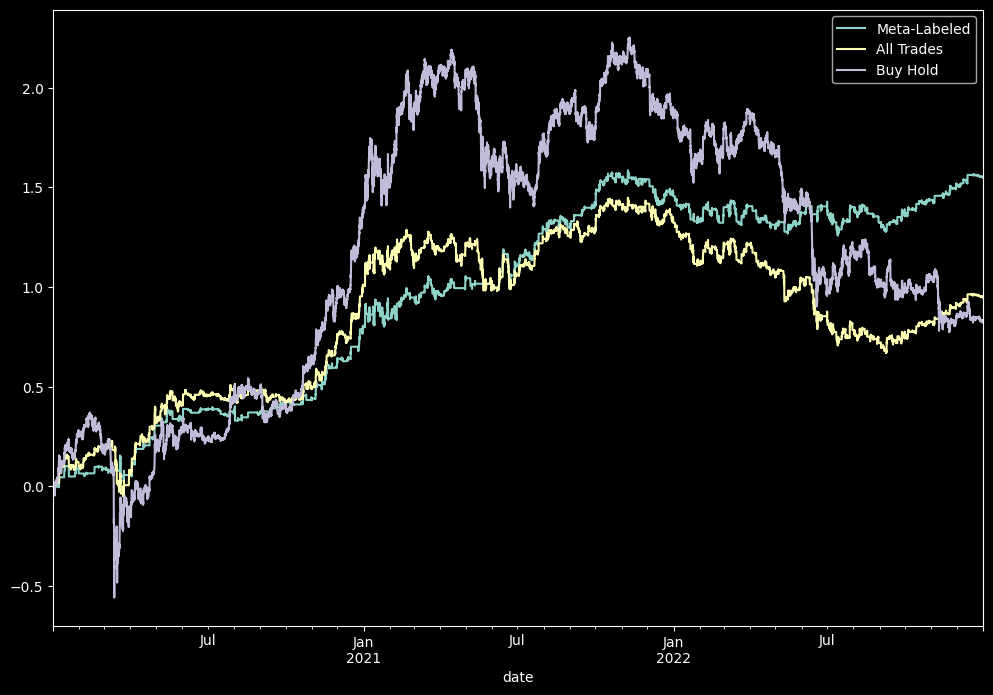

In [21]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
(data['r'] * data['sig']).cumsum().plot(label='Meta-Labeled')
(data['r'] * data['dumb_sig']).cumsum().plot(label='All Trades')
(data['r']).cumsum().plot(label='Buy Hold')
plt.legend()
plt.show()